# Transaction cost

In [1]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

import random

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from skfin.backtesting import Backtester
from skfin.datasets_ import load_kf_returns
from skfin.mv_estimators import MeanVariance
from skfin.plot import bar, line

import logging

logging.getLogger("skfin.datasets").setLevel(level=logging.CRITICAL)

returns_data = load_kf_returns(cache_dir="data")
ret = returns_data["Monthly"]["Average_Value_Weighted_Returns"][:"1999"]

transform_X = lambda x: x.rolling(12).mean()
transform_y = lambda x: x.shift(-1)
features = transform_X(ret)
target = transform_y(ret)

INFO:skfin.dataloaders.cache:Loading from cache : data/12_Industry_Portfolios


The goal of this section is to take transaction costs into account when evaluating a strategy. More precisely, discussing the cost of executing a trade requires an introduction to market microstructure. Beyond explicit costs, there are implicit trading costs that can significantly impact the pnl of a strategy. Intuititvely, the price will move against a party who wants to execute a significant trade -- ie. the price will increase (resp. decrease) as a party wants to buy (resp. sell) a significant amount of security. Crucially, this can happen even if no trading happens. 

In the context of this section, the impact of transaction is evaluated along two directions: 

- evaluate whether the strategy pnl covers costs; 

- improve the strategy so that the transaction costs are lower. 

The latter point generally highlights a tradeoff between alpha (trading quickly to avoid alpha decay) and costs (avoid costs from execessing trading). 

## Order book and trades 

In this section, we discuss the costs associated to trading following Section 3.7 in *Engineering Investment Process* by Ielpo, Merhy and Simon (2017). A rule of thumbs is 

> "It takes one day of volume to trade one day of volatility."

In other words: *the bigger trade, the higher the cost*. There are three main categories of trade execution: 

1. over-the-counter (OTC): the price of the transaction is directly negotiated with another market participant; 

1. delegated-execution: the trade is delegated to a broker with a guarantee of execution price (e.g. price at close or volume-weighted average price as VWAP). 

1. direct trade and execution on markets. 

At any given point in time, some market participants can make public their willingness to trade a quantity at a given price in an *order book*. More precisely, an order book refers to an electronic list of buy and sell orders for a specific security or financial instrument organized by price level.

The bid-ask spread is the difference between the highest price that a buyer is willing to pay for an asset and the lowest price that a seller is willing to accept. More precisely, there are two types of orders: 

1. market order: this is an instruction by an investor to a broker to buy or sell an assets at the best available price in the order book. 

1. limit order: this is an instruction to a broker to buy or sell only a certain quantity at a certain price. 

There is a tradeoff between trading immediately at a known (and potentially high) price and trading later, but at an unknown time/date and for an unknown price. In this context, there are two different types of costs: 

- direct/explicit costs: commissions, brokerage fees, settlement/clearing fees, exchange fees, taxes. This also includes shorting costs with easy-to-borrow / hard-to-borrow rates. 

- indirect/implicit/impact costs: loosely, these costs capture the idea that the bigger the trade, the higher the cost. But typically, each investor faces impact costs depending on execution choice, execution pattern, latency, procedure speed and horizon. These impact costs are estimated based on (potentially private) past trades. 

## Impact costs

The figure below is from Ielpo et al. (2017, p. 239): 

- $p_0$: decision price 

- $p_T$: final price 

- $p_e$: average executing price 

- $p_{\infty}$: after the trade, the price reverts to a limit value

- $\text{slippage} = \frac{p_e}{p_0} -1$ 

- $\text{permanent impact} = \frac{p_{\infty}}{p_0} -1$

Given that trades are motivated by a view of the market (ie. some alpha opportunity), it is difficult to distinguish alpha et pure impact. 

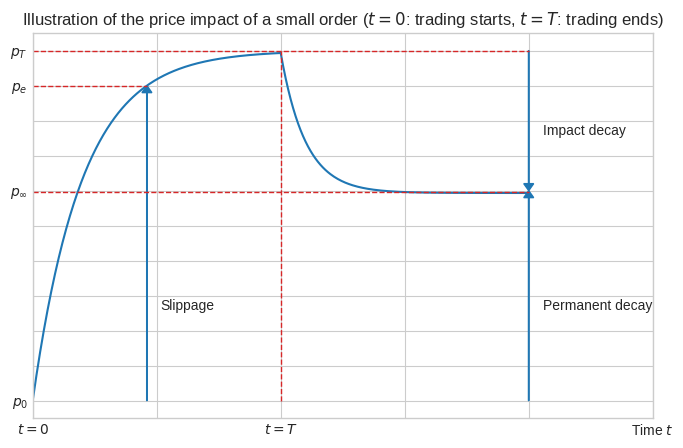

In [2]:
# hide
func1 = lambda x: 1 - np.exp(-10 * x)
inv_func1 = lambda y: -np.log(1 - y) / 10
func2 = lambda x: 0.8 * (1 - np.exp(-20 * x))

a = 0.5
b = 0.5
# c = 1
# c2 = 2.5
d = 0.0025

x1 = np.arange(0, a + 0.001, d)
x2 = np.arange(a, 1, d)


fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(x1, func1(x1))
ax.plot(x2, func1(a) - b * func2(x2 - a), color="tab:blue")
ax.plot(
    [0, 1], [0.6 - 0.005, 0.6 - 0.005], color="tab:red", linestyle="dashed", linewidth=1
)
ax.plot([0, 1], [1, 1], color="tab:red", linestyle="dashed", linewidth=1)
ax.plot([0.5, 0.5], [0, 1], color="tab:red", linestyle="dashed", linewidth=1)
ax.plot(
    [0, inv_func1(0.9)], [0.9, 0.9], color="tab:red", linestyle="dashed", linewidth=1
)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.set_yticklabels(
    ["$p_0$", "", "", "", "", "", "$p_\infty$", "", "", "$p_e$", "$p_T$"], rotation=0
)
ax.set_xlim([0, 1.25])
ax.set_xticks([0, 0.25, 0.5, 0.75, 1, 1.25])
ax.set_xticklabels(["$t=0$", "", "$t=T$", "", "", "Time $t$"], rotation=0)
plt.arrow(
    x=1,
    y=1,
    dx=0,
    dy=-0.4,
    head_width=0.02,
    head_length=0.02,
    color="tab:blue",
    length_includes_head=True,
)
plt.annotate("Impact decay", xy=(1, 0.8), xytext=(10, -10), textcoords="offset points")
plt.arrow(
    x=1,
    y=0,
    dx=0,
    dy=0.6,
    head_width=0.02,
    head_length=0.02,
    color="tab:blue",
    length_includes_head=True,
)
plt.annotate(
    "Permanent decay", xy=(1, 0.3), xytext=(10, -10), textcoords="offset points"
)
plt.arrow(
    x=inv_func1(0.9),
    y=0,
    dx=0,
    dy=0.9,
    head_width=0.02,
    head_length=0.02,
    color="tab:blue",
    length_includes_head=True,
)
plt.annotate(
    "Slippage", xy=(inv_func1(0.9), 0.3), xytext=(10, -10), textcoords="offset points"
)
ax.set_title(
    "Illustration of the price impact of a small order ($t=0$: trading starts, $t=T$: trading ends)"
);

In practice, we define the impact cost as a function $I$: 

$$ Q \mapsto I(Q), $$

where $Q$ is the traded quantities. The price impact in dollars of trading the quantity $Q$ is 

$$\text{ImpactCost} = Q \times I(Q).$$ 

The fraction of traded volume is $\delta = \frac{Q_{n, t}}{\text{Liquidity}_{n, t}}$ can be interpreted as time -- e.g. how many days (or fraction of a day) to trade $Q_{n, t}$ given the asset liquidity $\text{Liquidity}_{n, t}$. Over that period, the asset volatility scaled in $\sigma_{n, t} \sqrt{\delta}$, so that a simple impact model is: 

$$ I(Q) = \sigma \sqrt{\frac{Q}{\text{Liquidity}}}.$$

More generally, two parameters $\langle \gamma, \beta \rangle$ are fitted with the functional form: 

$$ I(Q) = \gamma \sigma \left(\frac{Q}{\text{Liquidity}}\right)^{\beta}.$$

A rule of thumb is as follows: 

- for small horizons, $\beta \approx 0$, $I(Q)$ is constant (e.g. bid-ask spread) and the total cost is linear; 

- for long horizons, $\beta \approx 1$ and the total impact cost $Q \times I(Q)$ is quadratic.

In  analytically more complex (and potentially more realistic) setups, $\beta$ is taken to be $1/2$ as motivated above. 

In what follows, we focus on quadratic impact cost with $\beta=1$.

## Mean-variance optimisation with quadratic costs

With quadratic cost, the mean-variance optimisation can be solved in closed form. More precisely, the mean-variance utility at time $t$ with transaction cost is  
$$h_t^T \alpha - \frac{h_t V h_t}{2 \lambda} - \frac{(h_t - h_{t-1})^T \Lambda (h_t - h_{t-1})}{2}, $$

where $\Lambda$ is a liquidity factor on each asset. 

**Lemma**.  Given the mean-variance utility with quadratic cost, the optimal portfolio is 

$$h_t  = \left[\frac{V}{\lambda} + \Lambda \right]^{-1}(\alpha + \Lambda h_{t-1}).$$

*Proof*. The mean-variance objective is rewritten as 
$$ h_t^T (\alpha + \Lambda h_{t-1}) - \frac{h_t (V + \lambda \Lambda) h_t}{2 \lambda} - \frac{h_{t-1}^T \Lambda h_{t-1}}{2}$$

The optimal portfolio with transaction cost is a weighted average of two holdings: 
$$h_t  = (I  + \lambda V^{-1}\Lambda)^{-1}\lambda V^{-1}\alpha + [I -  (I  + \lambda V^{-1}\Lambda)^{-1}] h_{t-1}.$$

Interpretation: 

-  the friction-less mean-variance portfolio $\lambda V^{-1}\alpha$ is the target portfolio 

- the optimal portfolio $h_t$ is a weighted-average of this target portfolio and the past holdings $h_{t-1}$: 

- ideally the investor would like to hold the target portfolio but because of transaction cost, it only trades partially towards this target. 

-  when the transaction costs are lower and the risk-tolerance $\lambda$ is higher, the investor loads more on the mean-variance target $\lambda V^{-1}\alpha$

- the transaction imply so form of (non-linear) exponential averaging. 

## Positions and turnover

In previous sections, the positions $h_t$ have been rescaled so that 

$$ \sqrt{h_t^T V_t h_t} = 1$$

and 

$$ \sum_t h_{n, t} = 0.$$

More generally the positions are denominated in dollars as: 

$$pos_t = \theta \times h_t, $$ 

where the scaler is a risk target in dollars:  $\theta = \sqrt{pos_t^T V_t pos_t}.$ Given this risk target, the (two-sided) gross  leverage 
$$ \text {Leverage} = \sum_{n} | pos_{n,t}|$$  

From (rescaled) positions in asset $n$ are denoted $h_{n, t}$, the trades *quantities* are: 
    
$$ q_{n, t}  = pos_{n, t} - (1+r_t) pos_{n, t-1}.$$ 

- (One-sided) turnover 
$$ \text {TrueTurnover}_t = \sum_{n} | pos_{n,t} - (1+r_{t}) pos_{n,t-1} |/2$$
where $h_{n,t} - (1+r_{n,t}) h_{n,t-1}$ is the trade. In most of what we do, approximating the small returns away is good enough: 

$$ \text {Turnover}_t = \sum_{n} | pos_{n,t} - pos_{n,t-1} |/2 $$ 

The portfolio average holding period refers to the average length of time that investments are held within a portfolio before being sold or replaced. It is a measure often used to assess the turnover rate of the portfolio, providing insight into the investment strategy being employed—whether it is more short-term or long-term in nature. 

$$  \text {HP} = \frac{\frac{1}{T} \sum_{t=1}^T \text {Leverage}_t}{\frac{1}{T} \sum_{t=1}^T\text{Turnover}_t}$$

## Cost for the Industry Momentum backtest

Given that the data is monthly, we re-estimate the model every month and the maximum train window is 12 months. 

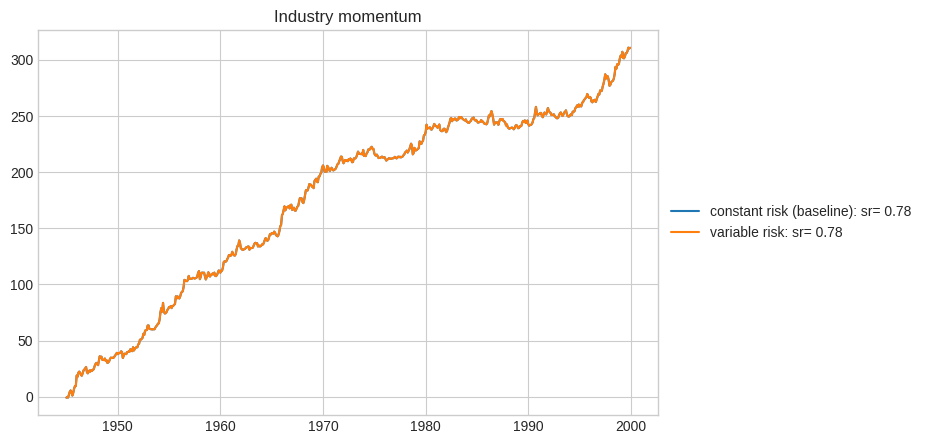

In [3]:
estimators_ = {
    "constant risk (baseline)": MeanVariance(risk_target=1),
    "variable risk": MeanVariance(risk_target=None),
}
line(
    {k: Backtester(v).train(features, target, ret) for k, v in estimators_.items()},
    cumsum=True,
    title="Industry momentum",
)

### Leverage and turnover

In [4]:
def average_holding_period(h):
    h = h.squeeze()
    if isinstance(h, pd.Series):
        return h.abs().mean() / h.diff().abs().div(2).mean()
    else:
        return h.abs().sum(axis=1).mean() / h.diff().abs().sum(axis=1).div(2).mean()

In [5]:
m0 = (
    Backtester(MeanVariance(risk_target=None))
    .compute_holdings(features, target)
    .compute_pnl(ret)
)


hp = average_holding_period(m0.h_)

print(f"The average holding period is {hp:.2f} months")

The average holding period is 5.53 months


### Liquidity and market cap

Given that we do not have data on sector liquidity, we use the market capitalisation as a proxy for liquidity. 

In [6]:
mcap = returns_data["Monthly"]["Average_Firm_Size"].mul(
    returns_data["Monthly"]["Number_of_Firms_in_Portfolios"]
)

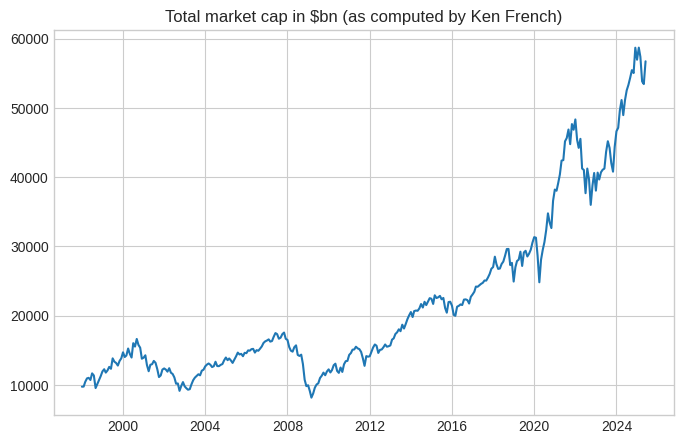

In [7]:
line(
    mcap.loc["1998":].sum(axis=1).div(1e3),
    title="Total market cap in $bn (as computed by Ken French)",
    legend=False,
)

In [8]:
gamma = 1 / 20
mcap_norm = mcap.div(mcap.sum(axis=1), axis=0)
vol_liquidity_factor = 0.5 * gamma * ret.rolling(12).std().div(mcap_norm.loc[ret.index])

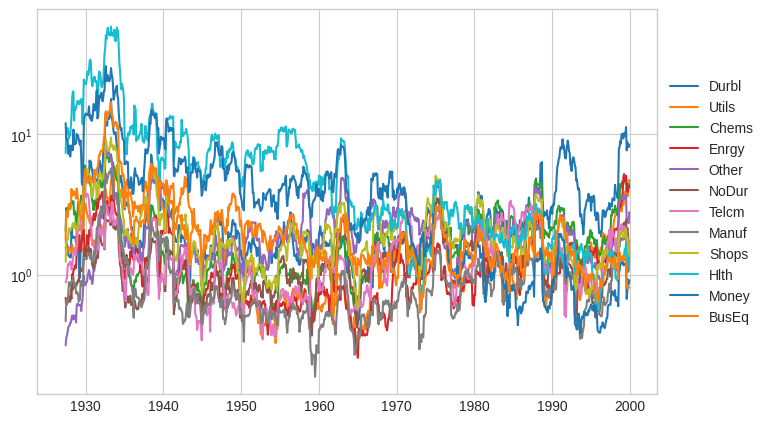

In [9]:
line(vol_liquidity_factor, yscale="log")

### Mark-to-market and backtesting

In this case, $\Lambda$ is the diagonal of the vector of return standard deviations over market capitalisation (as a proxy for liquity -- e.g. traded volume).

In [10]:
%%writefile ../skfin/backtesting_with_cost.py
from dataclasses import dataclass

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, clone
from sklearn.model_selection import TimeSeriesSplit
from skfin.mv_estimators import MeanVariance 


def compute_pnl_components(h, ret, vol_liquidity_factor=None):
    ret = ret[h.index[0] : h.index[-1]]
    vol_liquidity_factor = vol_liquidity_factor.loc[h.index[0] : h.index[-1]]

    pnl = h.shift(1).mul(ret).sum(axis=1)
    if vol_liquidity_factor is not None:
        impact_cost = h.diff().pow(2).mul(vol_liquidity_factor).sum(axis=1)
        return {
            "gross": pnl,
            "net = gross - impact cost": pnl.sub(impact_cost),
            "impact cost": -1 * impact_cost,
        }
    else:
        return pnl


def compute_batch_holdings_with_cost(
    pred, V, A=None, past_h=None, vol_liquidity_factor=None, lambda_=None, risk_target=None
):
    """
    compute markowitz holdings with return prediction "mu" and covariance matrix "V"

    mu: numpy array (shape N * K)
    V: numpy array (N * N)

    """
    if (lambda_ is None) & (vol_liquidity_factor is not None):
        lambda_ = 1
    N, _ = V.shape
    if isinstance(pred, pd.Series) | isinstance(pred, pd.DataFrame):
        pred = pred.values
    if pred.shape == (N,):
        pred = pred[:, None]
    elif pred.shape[1] == N:
        pred = pred.T

    if vol_liquidity_factor is not None:
        invV = np.linalg.inv(V / lambda_ + 2 * np.diag(vol_liquidity_factor))
    else:
        invV = np.linalg.inv(V)
    if A is None:
        M = invV
    else:
        U = invV.dot(A)
        if A.ndim == 1:
            M = invV - np.outer(U, U.T) / U.dot(A)
        else:
            M = invV - U.dot(np.linalg.inv(U.T.dot(A)).dot(U.T))
    if (vol_liquidity_factor is not None) & (past_h is not None):
        h = M.dot(pred + 2 * np.diag(vol_liquidity_factor).dot(past_h.T))
    else:
        h = M.dot(pred)
    return h.T


@dataclass
class MeanVarianceWithCost(MeanVariance):
    """
    Mean-variance optimization estimator with transaction cost considerations.
    """
    @staticmethod
    def compute_batch_holdings(pred, V, A, **kwargs):
        """
        Compute portfolio holdings considering transaction costs.

        Parameters:
            pred (np.ndarray): Predicted returns.
            V (np.ndarray): Covariance matrix.
            A (np.ndarray): Constraint matrix.
            **kwargs: Additional keyword arguments.

        Returns:
            np.ndarray: Portfolio holdings considering costs.
        """
        return compute_batch_holdings_with_cost(pred, V, A, **kwargs)


@dataclass 
class BacktesterWithCost:
    estimator: BaseEstimator = MeanVarianceWithCost()
    vol_liquidity_factor: pd.DataFrame=None
    max_train_size: int=36
    test_size: int=1
    start_date: str="1945-01-01"
    end_date: str=None
    h_init: pd.Series=None
    return_pnl_component: bool=False

    def train(self, X, y, ret):
        X = X.loc[:self.end_date]
        cv = TimeSeriesSplit(
            max_train_size=self.max_train_size,
            test_size=self.test_size,
            n_splits=1 + len(X.loc[self.start_date : ]) // self.test_size,
        )
        
        _h = []
        past_h = self.h_init
        for train, test in cv.split(X):
            m = clone(self.estimator)
            m.fit(X.iloc[train], y.iloc[train])
            if self.vol_liquidity_factor is None:
                vlf = None
            else:
                vlf = np.squeeze(self.vol_liquidity_factor.values[test])
            current_h = m.predict(
                X.iloc[test], past_h=past_h, vol_liquidity_factor=vlf
            )
            _h += [current_h]
            past_h = current_h

        cols = X.columns
        idx = X.index[np.concatenate([test for _, test in cv.split(X)])]
        h_ = pd.DataFrame(np.concatenate(_h), index=idx, columns=cols)

        self.h_ = h_
        if self.return_pnl_component:
            self.pnl_ = compute_pnl_components(
                self.h_, ret, vol_liquidity_factor=self.vol_liquidity_factor
            )
        else:
            self.pnl_ = (
                h_.shift(1).mul(ret).sum(axis=1)[self.start_date : self.end_date]
            )
        return self

Overwriting ../skfin/backtesting_with_cost.py


In [11]:
from skfin.backtesting_with_cost import compute_pnl_components

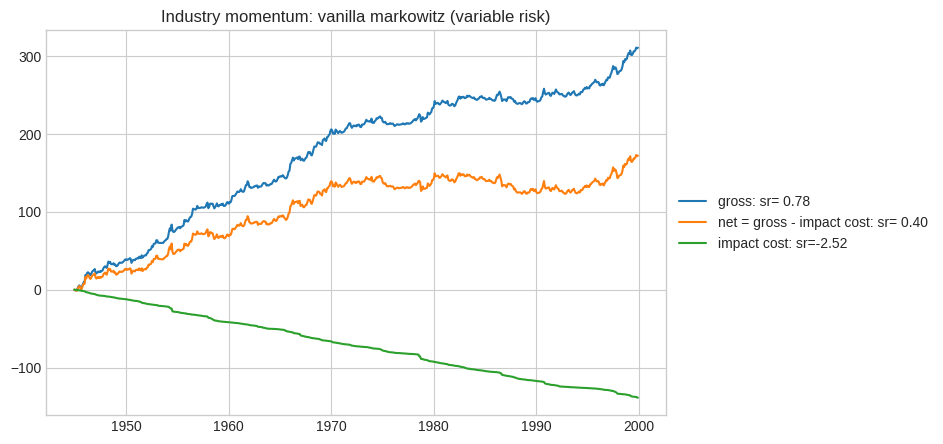

In [12]:
pnlc = compute_pnl_components(m0.h_, ret, vol_liquidity_factor=vol_liquidity_factor)
line(pnlc, cumsum=True, title="Industry momentum: vanilla markowitz (variable risk)")

### Backtesting with cost

In [13]:
from skfin.backtesting_with_cost import BacktesterWithCost, MeanVarianceWithCost

In [14]:
m0_ = BacktesterWithCost(MeanVarianceWithCost(), vol_liquidity_factor=None).train(
    features, target, ret
)
np.allclose(m0_.pnl_, m0.pnl_)

True

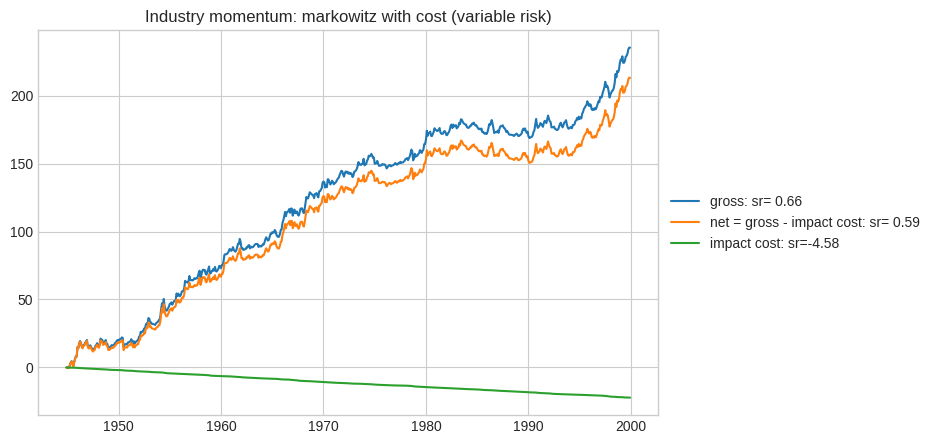

In [15]:
m = BacktesterWithCost(
    MeanVarianceWithCost(), vol_liquidity_factor, return_pnl_component=True
).train(features, target, ret)
line(
    m.pnl_, cumsum=True, title="Industry momentum: markowitz with cost (variable risk)"
)

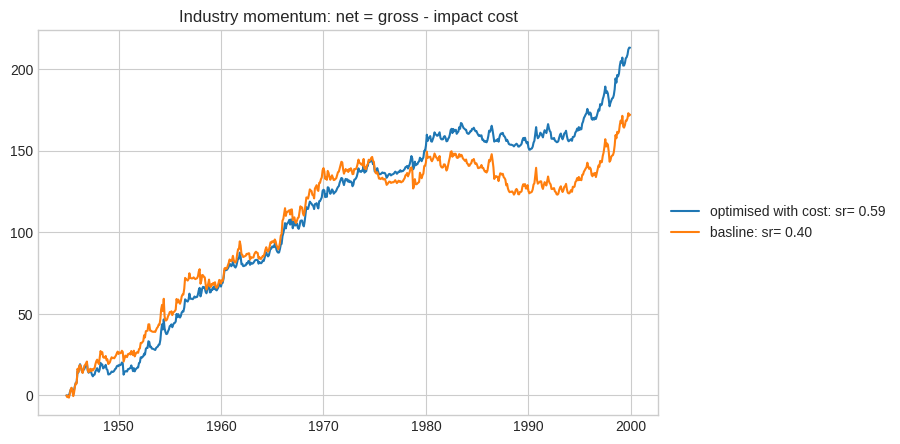

In [16]:
c = "net = gross - impact cost"
line(
    {"basline": pnlc[c], "optimised with cost": m.pnl_[c]},
    cumsum=True,
    title=f"Industry momentum: {c}",
)

Comparing the average holding periods, we see a sharp increase. 

In [17]:
print(
    f"Average holding period (in month):\n - baseline = {average_holding_period(m0.h_):.1f},\n - optimised with quadratic cost = {average_holding_period(m.h_):.1f}."
)

Average holding period (in month):
 - baseline = 5.5,
 - optimised with quadratic cost = 10.3.


The scatterplot below shows at the industry level: 
    
- the average liquidity factor
- the average holding period 

Intuitive, the more expensive it is to trade a sector, the longer the holding period should be. 

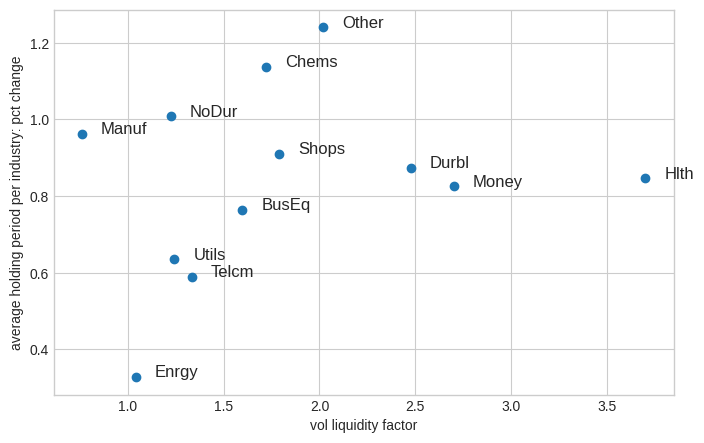

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

avp = (
    pd.Series({c: average_holding_period(m.h_[c]) for c in m0.h_.columns})
    .div(pd.Series({c: average_holding_period(m0.h_[c]) for c in m0.h_.columns}))
    .sub(1)
)

df = pd.concat(
    {
        "vol liquidity factor": vol_liquidity_factor.loc[m0.h_.index[0] :].mean(),
        "average holding period per industry: pct change": avp,
    },
    axis=1,
)

cols = list(df.columns)
idx = list(df.index)

ax.scatter(df.iloc[:, 0].values, df.iloc[:, 1].values)
ax.set_xlabel(cols[0])
ax.set_ylabel(cols[1])
xshift, yshift, rotation = 0.1, 0, 0
for i, txt in enumerate(idx):
    ax.text(
        df.iloc[i, 0] + xshift,
        df.iloc[i, 1] + yshift,
        txt,
        fontsize=12,
        rotation=rotation,
    )

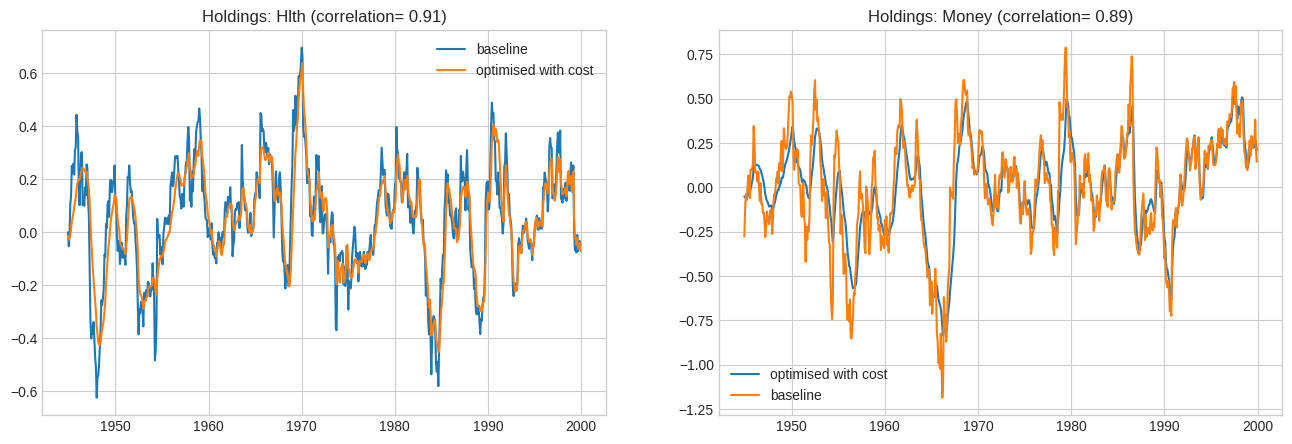

In [19]:
cols = ["Hlth", "Money"]
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
for i, c in enumerate(cols):
    df = pd.concat({"baseline": m0.h_[c], "optimised with cost": m.h_[c]}, axis=1)
    line(
        df,
        title=f"Holdings: {c} (correlation={df.corr().iloc[0, 1]: .2f})",
        ax=ax[i],
        loc="best",
    )

For healthcare, the volatility/liquidity factor seems high on average, but decreases sharply over the period -- which explains that the average holding period increases less than expected. 

### Ridge backtest with cost

In [20]:
from skfin.estimators import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

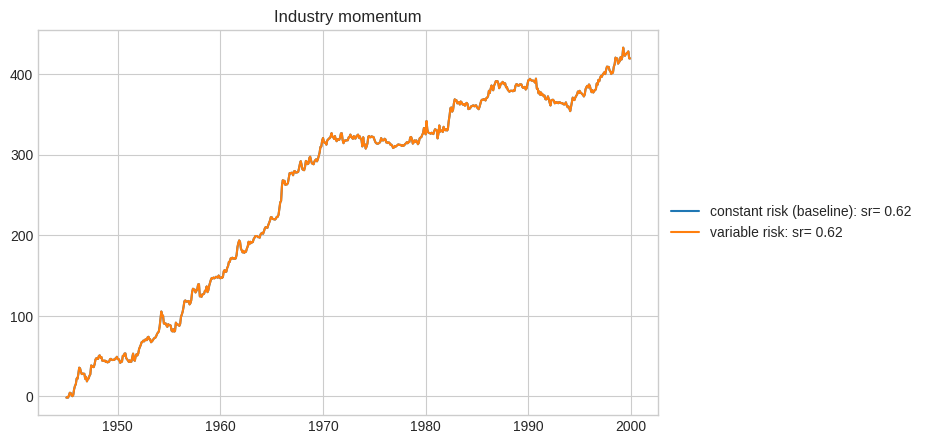

In [21]:
estimators_ = {
    "constant risk (baseline)": make_pipeline(
        StandardScaler(with_mean=False), Ridge(), MeanVariance(risk_target=1)
    ),
    "variable risk": make_pipeline(
        StandardScaler(with_mean=False), Ridge(), MeanVariance(risk_target=None)
    ),
}
line(
    {k: Backtester(v).train(features, target, ret) for k, v in estimators_.items()},
    cumsum=True,
    title="Industry momentum",
)

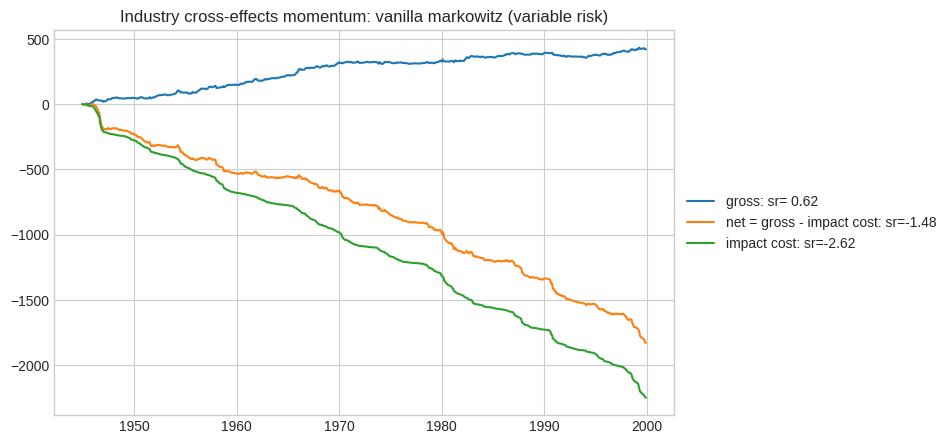

In [22]:
estimator_ = make_pipeline(
    StandardScaler(with_mean=False), Ridge(), MeanVarianceWithCost()
)
m0_ = BacktesterWithCost(estimator_, vol_liquidity_factor=None).train(
    features, target, ret
)

pnlc = compute_pnl_components(m0_.h_, ret, vol_liquidity_factor=vol_liquidity_factor)
line(
    pnlc,
    cumsum=True,
    title="Industry cross-effects momentum: vanilla markowitz (variable risk)",
)

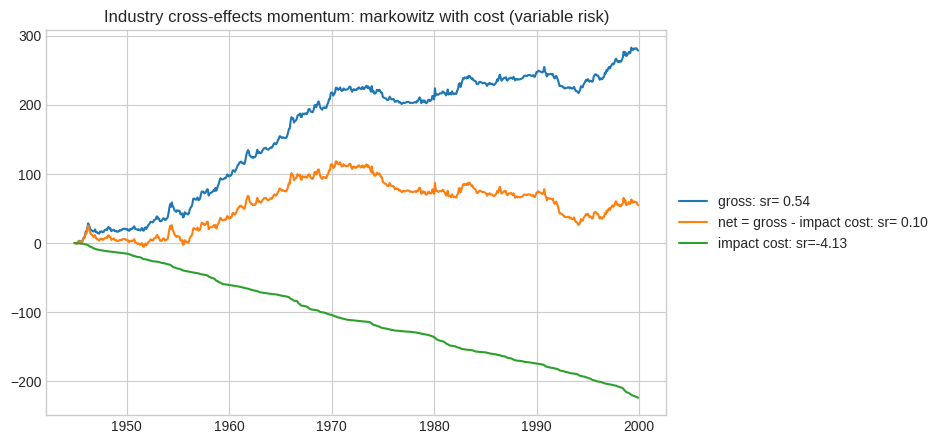

In [23]:
m_ = BacktesterWithCost(
    estimator_,
    vol_liquidity_factor=vol_liquidity_factor,
    return_pnl_component=True,
).train(features, target, ret)
line(
    m_.pnl_,
    cumsum=True,
    title="Industry cross-effects momentum: markowitz with cost (variable risk)",
)

A key difference between the baseline industry momentum strategy and the strategies that lean cross-effects (e.g. learning with a Ridge estimator) is these strategies are faster. In this case, taking cost into account to slow down the strategy is even more important. 

In [24]:
print(
    f"Average holding period (in month):\n - baseline Ridge = {average_holding_period(m0_.h_):.1f},\n - optimised with quadratic cost = {average_holding_period(m_.h_):.1f}."
)

Average holding period (in month):
 - baseline Ridge = 2.5,
 - optimised with quadratic cost = 4.5.
